#  Features engineering

The aim of this phase is to analyse possible features, it's correlation with dependant variable 'delayInSeconds' and create new features on the basis of existing ones that may add more value to the model

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set column types to minimize dataframe
column_types= {'agencyId': 'int16',
 'clouds_all': 'int8',
 'delayInSeconds': 'int64',
 'humidity': 'int8',
 'id': 'int32',
 'pressure': 'int16',
 'routeId': 'int16',
 'stopId': 'int32',
 'stopLat': 'float64',
 'stopLon': 'float64',
 'stopSequence': 'int32',
 'temp': 'float64',
 'tripId': 'int16',
 'vehicleId': 'int32',
 'wind_deg': 'int16',
 'wind_speed': 'int8'}

In [3]:
# read previously cleaned Dataframe
df=pd.read_csv('df_cleaned', dtype=column_types, parse_dates=['delayPredictionTimestamp','scheduleTime'])

In [4]:
# have a look on data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499999 entries, 0 to 499998
Data columns (total 19 columns):
id                          499999 non-null int32
stopId                      499999 non-null int32
routeId                     499999 non-null int16
vehicleId                   499999 non-null int32
tripId                      499999 non-null int16
delayPredictionTimestamp    499999 non-null datetime64[ns]
scheduleTime                499999 non-null datetime64[ns]
delayInSeconds              499999 non-null int64
stopSequence                499999 non-null int32
agencyId                    499999 non-null int16
stopLat                     499999 non-null float64
stopLon                     499999 non-null float64
temp                        499999 non-null float64
pressure                    499999 non-null int16
humidity                    499999 non-null int8
wind_speed                  499999 non-null int8
wind_deg                    499999 non-null int16
clouds_all       

I will now draw scatter plots of all features to analyse correlations and see which features are worth feature engineering. I will remove from graphs delays over 20000s and below -20000s to focus on area where the majority of observations exist.

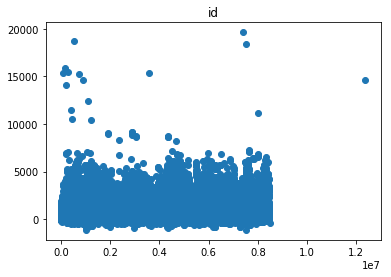

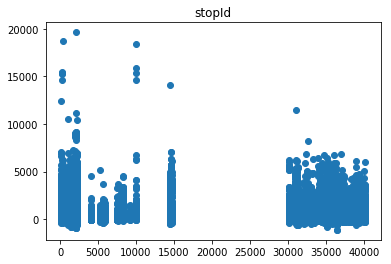

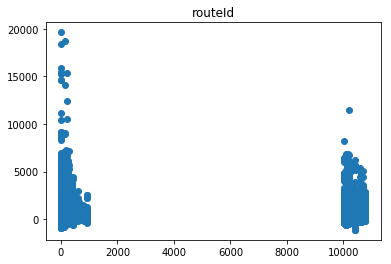

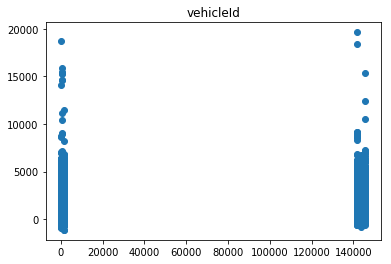

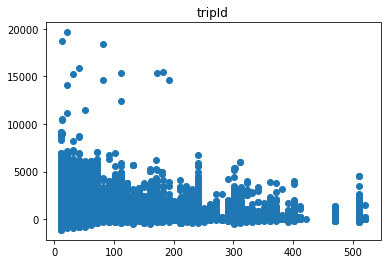

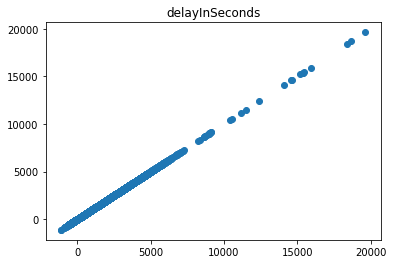

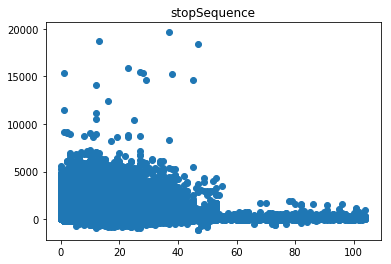

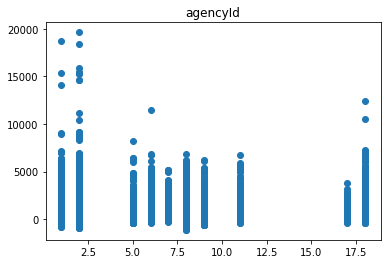

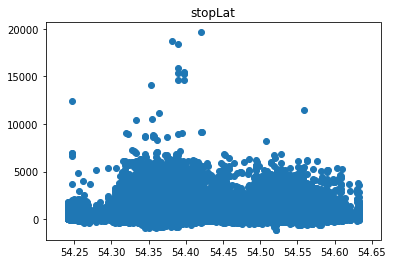

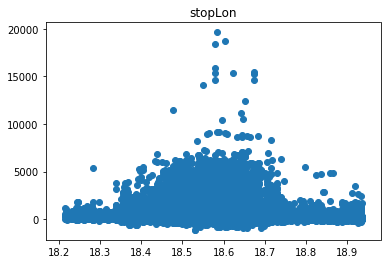

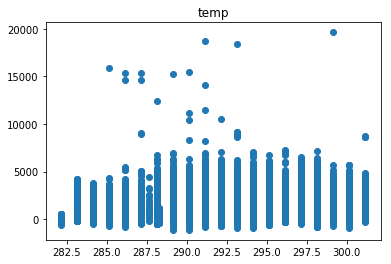

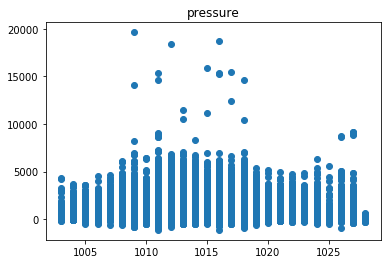

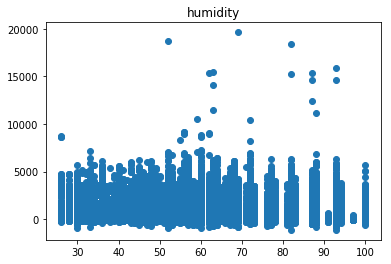

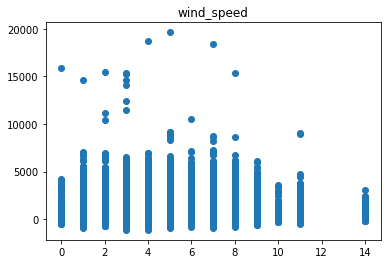

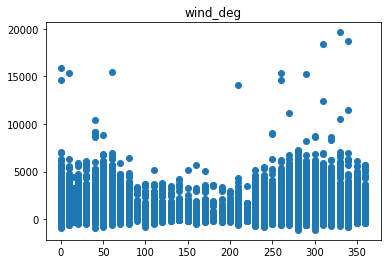

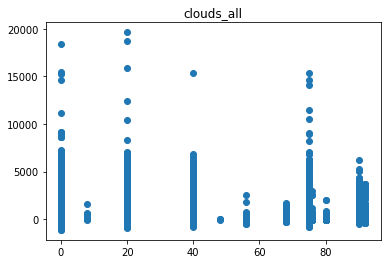

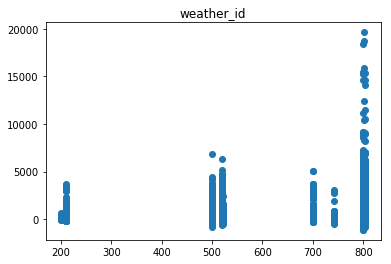

In [5]:
# draw scatter plots
no_outliers= (df['delayInSeconds']>-20000) & (df['delayInSeconds']<20000)
for col in df.columns:
    if(df[col].dtype in [np.int64, np.int32, np.int16, np.int8 ,np.float64]):
        fig=plt.figure()
        ax=fig.gca()
        ax.scatter(df[no_outliers][col], df[no_outliers]['delayInSeconds'])
        ax.set_title(col)

Now I'll check correletion between possible features and dependant variable

In [6]:
# Check spearman rank correlation
df.corr(method='spearman')['delayInSeconds']

id                0.001134
stopId            0.111246
routeId           0.125041
vehicleId         0.122435
tripId            0.027678
delayInSeconds    1.000000
stopSequence      0.287782
agencyId          0.130488
stopLat           0.106981
stopLon          -0.107762
temp              0.105447
pressure         -0.014413
humidity         -0.085419
wind_speed        0.043554
wind_deg         -0.018941
clouds_all        0.011142
weather_id        0.013835
Name: delayInSeconds, dtype: float64

Findings: 
'stopSequence'- seems to be good feature;
'agencyId', 'routeId', 'stopId', 'vehicleId'- have some influence on delay, but these are IDs. May be worth calculating mean delay per those features to create more meaningful ones;
stopLat, stopLon- localization have some impact on delay. May be worth to combine those 2 features using K-means clustering

I will now analyze possible mean delays features

In [7]:
# check if there is a difference in delay depending on stopId
df[ ['stopId','delayInSeconds'] ].groupby(['stopId']).mean().head(10)

,delayInSeconds
stopId,
100,44.500000
101,265.524390
102,254.886700
103,490.589286
110,65.607477
114,193.137363
115,130.722090
116,123.408360
117,467.832936


There is significant difference in delay depending on stopId. Let's create feature presenting mean delay per stopId and check how it's correleted with 'delayInSeconds'

In [8]:
# create feature presenting mean delay per stopId
stopIdMeanDelay = df[ ['stopId', 'delayInSeconds'] ].groupby(['stopId']).mean().to_dict()['delayInSeconds']
df['stopIdMeanDelay'] = df['stopId'].map(lambda x: stopIdMeanDelay[x])

In [9]:
# check new feature correlation with delay
df['stopIdMeanDelay'].corr(df['delayInSeconds'],method='spearman')

0.3455776969584149

Mean delay per stopID is more correlated with delays than stopId. This may be a good feature. I will create more such features:

In [10]:
# create mean delay features per 'agencyID', 'routeID', 'vehicleId', 'tripId'.
agencyMeanDelay = df[ ['agencyId', 'delayInSeconds'] ].groupby(['agencyId']).mean().to_dict()['delayInSeconds']
df['agencyMeanDelay'] = df['agencyId'].map(lambda x: agencyMeanDelay[x])
routeMeanDelay = df[ ['routeId', 'delayInSeconds'] ].groupby(['routeId']).mean().to_dict()['delayInSeconds']
df['routeMeanDelay'] = df['routeId'].map(lambda x: routeMeanDelay[x])
vehicleIdMeanDelay = df[ ['vehicleId', 'delayInSeconds'] ].groupby(['vehicleId']).mean().to_dict()['delayInSeconds']
df['vehicleIdMeanDelay'] = df['vehicleId'].map(lambda x: vehicleIdMeanDelay[x])
tripIdMeanDelay = df[ ['tripId', 'delayInSeconds'] ].groupby(['tripId']).mean().to_dict()['delayInSeconds']
df['tripIdMeanDelay'] = df['tripId'].map(lambda x: tripIdMeanDelay[x])

In [11]:
print ('agencyMeanDelay ' + str(np.round(df['agencyMeanDelay'].corr(df['delayInSeconds'],method='spearman'),3)))
print ('routeMeanDelay ' + str(np.round(df['routeMeanDelay'].corr(df['delayInSeconds'],method='spearman'),3)))
print ('vehicleIdMeanDelay ' + str(np.round(df['vehicleIdMeanDelay'].corr(df['delayInSeconds'],method='spearman'),3)))
print ('tripIdMeanDelay ' + str(np.round(df['tripIdMeanDelay'].corr(df['delayInSeconds'],method='spearman'),3)))

agencyMeanDelay 0.136
routeMeanDelay 0.228
vehicleIdMeanDelay 0.174
tripIdMeanDelay 0.109


'routeMeanDelay' seems to be good feature. I'll leave all created features for the time being and test in model creation phase which to leave, which to remove

I will now check if 'delay depends on 'stopId' location

Text(0,0.5,'stopLon')

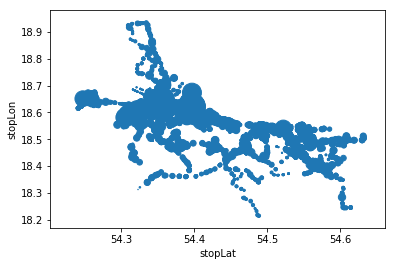

In [12]:
# draw delay depending on location
scale=df['delayInSeconds'].apply(lambda x: x/100 if x>0 else 0)
plt.scatter(df['stopLat'],df['stopLon'],s=scale)
plt.xlabel('stopLat')
plt.ylabel('stopLon')

There is a correlation between stopId location and delay. There are higher delays in specific regions of the city of Gdańsk. I will use Kmeans clustering to create few clusters of location.

In [13]:
# use Kmeans clustering to group locations
from sklearn.cluster import KMeans
X = df[['stopLat','stopLon']].values
kmeans = KMeans(n_clusters=8, random_state=2018).fit(X)
df['clusters']=kmeans.predict(X)

In [14]:
# calculate median delay per cluster to see if it shows some differentiation in delay
df.groupby('clusters')['delayInSeconds'].median()

clusters
0     85.0
1    116.0
2     75.0
3     89.5
4     78.0
5     92.0
6     98.0
7    103.0
Name: delayInSeconds, dtype: float64

Text(0,0.5,'stopLon')

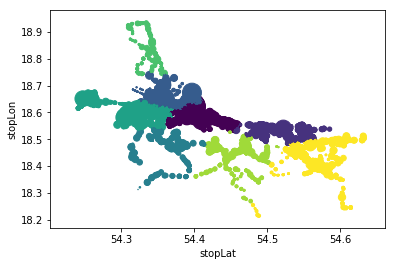

In [15]:
# draw clusters
scale=df['delayInSeconds'].apply(lambda x: x/100 if x>0 else 0)
plt.scatter(df['stopLat'],df['stopLon'],c=df['clusters'],s=scale)
plt.xlabel('stopLat')
plt.ylabel('stopLon')

After few trials decided to use 8 clusters to present difference in delays depending on location

There is a feature 'delayPredictionTimestamp' that presents the time of the last delay prediction made. If the prediction was made after 'schedule time' that should mean the bus was delayed. I will now check if the difference between 'delayPredictionTimestamp' and 'scheduleTime' may be a good feature.

In [16]:
# caluclate the difference between 'delayPredictionTimestamp' and 'scheduleTime'
df['time_diff']=(df['delayPredictionTimestamp']-df['scheduleTime']).astype('timedelta64[s]')
df['time_diff']=pd.to_numeric(df['time_diff'], downcast='signed')

In [17]:
df['time_diff'].corr(df['delayInSeconds'],method='spearman')

0.8264713146661401

The correlation is not as high as I supposed. I will now have a look on time_diff distribution

Text(0.5,0,'time_diff')

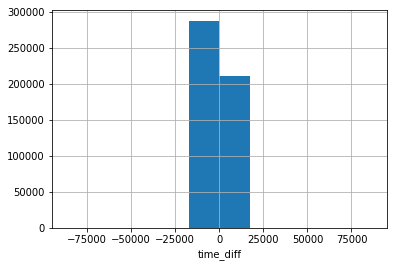

In [18]:
df['time_diff'].hist()
plt.xlabel('time_diff')

It looks like we have here same problem as in 'delayInSeconds'- some time differences are probably incorrect-24h too big or too small.  Maybe it can help me predict those errors in 'delayInSeconds'. In data preprocessing phase I realized that such error occure in 'delayInSeconds' on specific time: between 3:44:57 and 3:45:05. I'lll check if it's the same in time_diff.

In [19]:
df[(df['time_diff']>70000) | (df['time_diff']<-70000) ]['delayPredictionTimestamp'].sample(20)

69031    2018-06-19 23:59:53
314460   2018-07-09 00:01:08
196119   2018-06-30 00:12:00
330029   2018-07-10 23:59:21
166243   2018-06-27 23:59:56
23490    2018-06-15 23:59:49
462277   2018-07-22 00:01:41
210332   2018-06-30 23:59:10
315506   2018-07-09 23:59:50
374087   2018-07-13 23:59:16
111502   2018-06-23 00:01:05
398093   2018-07-15 23:59:58
479592   2018-07-23 23:59:42
296522   2018-07-07 23:59:48
460518   2018-07-21 23:59:54
224360   2018-07-02 23:58:52
395034   2018-07-15 23:59:10
454911   2018-07-20 23:28:38
315377   2018-07-09 23:59:39
47658    2018-06-17 00:38:50
Name: delayPredictionTimestamp, dtype: datetime64[ns]

This error occure close to midnight. It's a different type of error. It seems that date of 'delayPredictionTimestamp' is always same as 'schedule_time', while in reality it should be day before of after if bus is scheduled close to midnight. This won't help me predict errors in 'delayInSeconds' and can make time_diff feature less useful. I will correct those values by adding or subtracting 24h.

In [20]:
# realized that there is an error in date when schedule time was close to midnight and some time_diff are 24h to large or too small
df['time_diff']=df['time_diff'].apply(lambda x: x+86400 if x <-50000 else x)
df['time_diff']=df['time_diff'].apply(lambda x: x-86400 if x >50000 else x)

Let's check the correlation of 'time_diff' with 'delayInSeconds' again and draw it on the graph.

In [21]:
# Calculate correlation between 'time_diff' and 'delayInSeconds'
df['time_diff'].corr(df['delayInSeconds'],method='spearman')

0.8276949521254163

Text(0,0.5,'time_diff')

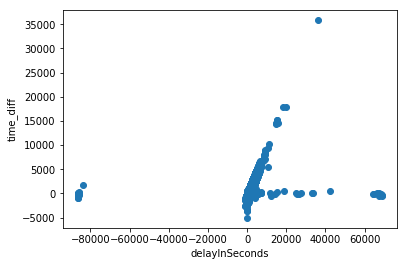

In [22]:
# Create scatter plot
plt.scatter(df['delayInSeconds'],df['time_diff'])
plt.xlabel('delayInSeconds')
plt.ylabel('time_diff')

Correlation is now much stronger. Now it should be a powerful feature.

I will not create new time features based on 'scheduleTime': hour, dayofweek, dayofweek, weekend- information if it's weekend or not, holiday- informaiton if it's holiday time or not. As I know that there is an error in data appearing during a few seconds of a day I will also create a seconds feature(which second of a day it is) to enable model to find this. 

In [23]:
# Create new features based on Schedule time
df['hour'] = df['scheduleTime'].dt.hour
df['dayofweek'] = df['scheduleTime'].dt.dayofweek
df['weekend'] = df['dayofweek'].map(lambda x: int(x in [5,6]))
df['dayofweek'] = df['scheduleTime'].dt.dayofweek
df['holidays'] = df['scheduleTime'].map(lambda x: int(x > pd.Timestamp(2018, 6, 22, 23, 59, 59)))
df['time']=df['delayPredictionTimestamp'].dt.second+df['delayPredictionTimestamp'].dt.minute*60+df['delayPredictionTimestamp'].dt.hour*3600

I think that the hours with higher delay may be different during the week and on weekends. I will check it.

Text(0,0.5,'median delayInSeconds')

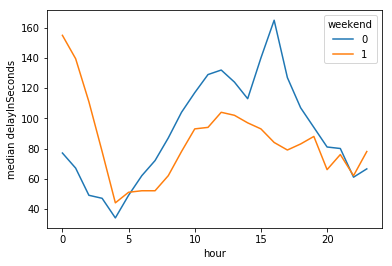

In [24]:
# Draw median delay by hour on weekdays and weekends
df.groupby(['hour','weekend'])['delayInSeconds'].median().unstack().plot()
plt.ylabel('median delayInSeconds')

In [25]:
# analyse diffence in median delay on each hour during working days and weekend
df.groupby(['hour','weekend'])['delayInSeconds'].median().unstack()

weekend,0,1
hour,,
0,77.0,155.0
1,67.0,139.5
2,49.0,111.0
3,47.0,78.0
4,34.0,44.0
5,49.0,51.0
6,62.0,52.0
7,72.0,52.0
8,87.0,62.0


Graph and table confirms that the peak hours when bus delays are higher are different during the week and on weekends. What suprise me is high median delay at midnight on weekends. I will look deeper into it.

Text(0,0.5,'delayInSeconds')

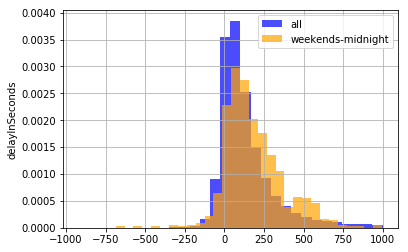

In [26]:
# draw delays distribution on midnight at weekends in comparison with whole delayInSecodns distribution
df[(df['delayInSeconds']>-1000) & (df['delayInSeconds']<1000)]['delayInSeconds'].hist(bins=30, color='blue', density=True, alpha=0.7, label='all')    
df[(df['hour']==0) & (df['weekend']==1) & (df['delayInSeconds']>-1000) & (df['delayInSeconds']<1000)]['delayInSeconds'].hist(bins=30, color='orange', density=True, alpha=0.7, label='weekends-midnight')
plt.legend()
plt.ylabel('delayInSeconds')

I do not see any errors here. It just seems that at midnight very few buses arrive before scheduled time and many of them arrive slighly delayed. 

 I will create a 'peak_hours' feature: 1 when median delay at the time  exceed 100, otherwise 0

In [27]:
# create 'peak_hours' feature
df['peak_hours']=(df[['hour','weekend']].apply(lambda x: (x['weekend'] == 1 and x['hour'] in (0,1,2,12,13,14)) or (x['weekend'] == 0 and  9 <= x['hour'] <= 18),axis=1))

I will now add function to add all new features at once and be able to easy test it during model creation

In [28]:
# create feats_engineering function
def feats_engineering(df):  
    
    # mean 'delayInSeconds'
    stopIdMeanDelay = df[ ['stopId', 'delayInSeconds'] ].groupby(['stopId']).mean().to_dict()['delayInSeconds']
    df['stopIdMeanDelay'] = df['stopId'].map(lambda x: stopIdMeanDelay[x])
    agencyMeanDelay = df[ ['agencyId', 'delayInSeconds'] ].groupby(['agencyId']).mean().to_dict()['delayInSeconds']
    df['agencyMeanDelay'] = df['agencyId'].map(lambda x: agencyMeanDelay[x])
    routeMeanDelay = df[ ['routeId', 'delayInSeconds'] ].groupby(['routeId']).mean().to_dict()['delayInSeconds']
    df['routeMeanDelay'] = df['routeId'].map(lambda x: routeMeanDelay[x])
    vehicleIdMeanDelay = df[ ['vehicleId', 'delayInSeconds'] ].groupby(['vehicleId']).mean().to_dict()['delayInSeconds']
    df['vehicleIdMeanDelay'] = df['vehicleId'].map(lambda x: vehicleIdMeanDelay[x])
    tripIdMeanDelay = df[ ['tripId', 'delayInSeconds'] ].groupby(['tripId']).mean().to_dict()['delayInSeconds']
    df['tripIdMeanDelay'] = df['tripId'].map(lambda x: tripIdMeanDelay[x])
    
     # clusters of stopId localization
    from sklearn.cluster import KMeans
    X = df[['stopLat','stopLon']].values
    kmeans = KMeans(n_clusters=8, random_state=2018).fit(X)
    df['clusters']=kmeans.predict(X)
    
    # difference between delayPrediction and schedule time. Wrong date when time close to midnight need to add or subtract 24h
    df['time_diff']=(df['delayPredictionTimestamp']-df['scheduleTime']).astype('timedelta64[s]')
    df['time_diff']=pd.to_numeric(df['time_diff'], downcast='signed')
    df['time_diff']=df['time_diff'].apply(lambda x: x+86400 if x <-50000 else x)
    df['time_diff']=df['time_diff'].apply(lambda x: x-86400 if x >50000 else x)
    
    # time features
    df['hour'] = df['scheduleTime'].dt.hour
    df['dayofweek'] = df['scheduleTime'].dt.dayofweek
    df['weekend'] = df['dayofweek'].map(lambda x: int(x in [5,6]))
    df['dayofweek'] = df['scheduleTime'].dt.dayofweek
    df['holidays'] = df['scheduleTime'].map(lambda x: int(x > pd.Timestamp(2018, 6, 22, 23, 59, 59)))
    df['time']=df['delayPredictionTimestamp'].dt.second+df['delayPredictionTimestamp'].dt.minute*60+df['delayPredictionTimestamp'].dt.hour*3600
    df['peak_hours']=(df[['hour','weekend']].apply(lambda x: (x['weekend'] == 1 and x['hour'] in (0,1,2,12,13,14)) or (x['weekend'] == 0 and  9 <= x['hour'] <= 18),axis=1))
    
    return df